# Set up a supercell of perfect fcc crystal and determine the lattice parameter

## Load some modules 

In [15]:
import numpy as np
import os
import shutil
import subprocess
from contextlib import chdir
import lammps_logfile
import matplotlib.pyplot as plt
%matplotlib inline

## Define a useful function

This cell defines a function which takes some details of a supercell and writes them to a file suitable for use with Lammps. You do not need to worry about the details for now, but note the form of the function definition:

    def write_lammps(supercell, atom_pos, atom_type=None, filename='lammps.txt', num_types=1):
    
The function takes the following arguments:
- `supercell`: this is a 3x3 array with the row being the vectors defining the edges of the supercell;
- `atom_pos`: an Nx3 array givein the cartesian coordinates of the atoms in the supercell;
- `atom_type`: is an optional array of size N giving the type identifier for each atom as an integer. By default each atom is assigned the same type of 1;
- `filename`: the name of the file to write the output to (optional);
- `num_types`: the number of distinct atom types in the supercell. Optional, defaults to 1.

Note that this isn't particularly well written code, but it does the job.

In [16]:
# Define a function to write out a file in the correct format for lammps
def write_lammps(supercell, atom_pos, atom_type=None, filename='lammps.txt', num_types=1):
    """Write out a supercell in Lammps format"""
    fo = open(filename,'w')
    header = '#Lammps coordinate file'
    fo.write(header)
    fo.write('\n')
    fo.write(str(np.shape(atom_pos)[0]) + ' atoms\n')
    fo.write('\n')
    fo.write(str(num_types) + ' atom types\n')
    fo.write('\n')
    fo.write('0.0 ' + str(supercell[0,0]) + ' xlo xhi\n')
    fo.write('0.0 ' + str(supercell[1,1]) + ' ylo yhi\n')
    fo.write('0.0 ' + str(supercell[2,2]) + ' zlo zhi\n')
    if abs(supercell[1,0]) + abs(supercell[2,0]) + abs(supercell[2,1]) > 1e-3:
        fo.write(str(supercell[1,0]) + ' ' + str(supercell[2,0]) + ' ' + str(supercell[2,1]) + ' xy xz yz\n')
    fo.write('\n')
    fo.write('Atoms\n')
    fo.write('\n')
    count = 1
    for i in range(np.shape(atom_pos)[0]):
        fo.write(str(count) + ' ')
        if atom_type is not None: 
            fo.write(str(int(atom_type[i])) + ' ') 
        else:
            fo.write('1 ') 
        fo.write(str(atom_pos[i,0]) + ' ' + str(atom_pos[i,1]) + ' ' + str(atom_pos[i,2]) + '\n')
        count = count + 1
    fo.flush()
    fo.close()
    return

## Build the crystal 

This code cell actually builds the crystal and stores in an array

In [17]:
# ------------- Set up the crystal definition
# Set initial lattice parameters to experimental values

a = 4.2   # Rough value of lattice parameter. Relaxation will do the rest

# Set up unit cell specification and basis
cell = np.array([
    [1.0,0.0,0.0],
    [0.0,1.0,0.0],
    [0.0,0.0,1.0]])
motif = (np.array([
    [0.0, 0.0, 0.0],
    [0.5, 0.5, 0.0],
    [0.5, 0.0, 0.5],
    [0.0, 0.5, 0.5]]))
motif_size = 4

# ------------- Set size of simulation
# Set size of supercell (number of unit cells in each direction)
block_size = np.array([10,10,10])
# Calculate vectors defining supercell box
supercell = np.zeros((3,3), dtype=float)
for s in range(3):
    supercell[s,:] = a * block_size[s] * cell[s,:]

# ------------- Calculate atomic coordinates in supercell
# Set up empty list to hold coordinates
r = []
# Loop over all unit cells and all atoms in motif and add atom positions to a list
for i in range(block_size[0]):
    for j in range(block_size[1]):
        for k in range(block_size[2]):
            for p in range(motif_size):
                pos = a * ( (i + motif[p,0])*cell[0,:] + (j + motif[p,1])*cell[1,:] + (k + motif[p,2])*cell[2,:] )
                r.append(pos.tolist())
# Get number of atoms in total
num_atoms = len(r)
# Convert list of atoms to an array
r = np.array(r)

## Select potential to use
Select which potential to use (check you have selected the correct one).

In [18]:
pair_styles = ['eam/alloy', 'eam/fs', 'eam/alloy', 'eam/alloy', 'eam/alloy', 'eam/alloy']
potential_files = ['Pot1.set', 'Pot2.eam.fs', 'Pot3.eam.alloy', 'Pot4.eam.alloy', 'Pot5.eam.alloy', 'Pot6.eam.fs']
potential_index = 4

potential_file = potential_files[potential_index]
pair_style = pair_styles[potential_index]

print('You have selected potential: ', potential_file)

You have selected potential:  Pot5.eam.alloy


## Set up a simulation folder

In [19]:
# ------------- Set up a folder for the simulation
path = './Simulations/' + 'potential_' + str(potential_index+1) +  '/'
if not os.path.exists(path):
    os.makedirs(path, mode=0o777)

## Write the crystal structure to a file
write out a suitable input file using the `write_lammps()` function defined above.

In [20]:
# ------------- Write out the file using the function
write_lammps(supercell, r, filename=path + 'lammps.txt')

## Copy Lammps instruction file
Copy the file of instructions for lammps to the simulation folder, making suitable amendments

In [21]:
# Define a function to replace text in base input file
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

# Create  a folder for simulation and copy in the empirical potential file
shutil.copy2('../Potentials/' + potential_file, path)

# Define values to replace in base input file
replacements = {
    'POTENTIAL':potential_file,
    'PAIRSTYLE':pair_style
    }
        
# Create a lammps file and use base file with string replacements to create unique variant
inputLammpsFile = 'in_base.lmps'
outputLammpsFile = path+'in.lmps'        
finLammps = open(inputLammpsFile, 'r').read()
foutLammps = open(outputLammpsFile, 'w')
out = replace_all(finLammps, replacements)
foutLammps.write(out)
foutLammps.close()

## Run the simulation


In [22]:
lammps_executable = 'lmp_serial'
lammps_command = '-in in.lmps'

with chdir(path):
    os.system(lammps_executable + ' ' + lammps_command)

LAMMPS (2 Aug 2023 - Update 3)
Reading data file ...
  orthogonal box = (0 0 0) to (42 42 42)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  4000 atoms
  read_data CPU = 0.009 seconds
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 8.28721
  ghost atom cutoff = 8.28721
  binsize = 4.143605, bins = 11 11 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
Setting up cg style minimization ...
  Unit style    : metal
  Current step  : 0
 (src/min.cpp:228)
Per MPI rank memory allocation (min/avg/max) = 5.475 | 5.475 | 5.475 Mbytes
   Step         PotEng           Lx             Ly             Lz            Pxx            Pyy            Pzz            Fmax          Fnorm     
         0  -13244.988      42           

In [23]:
lammps_executable + ' ' + lammps_command

'lmp_serial -in in.lmps'

## Check the results from the simulation 

These cells are for use after the simulation has run, to examine the output.

First read in data from the logfile

In [24]:
log = lammps_logfile.File(path + 'log.lammps')

step = log.get("Step")
pe = log.get("PotEng")
length = log.get("Lx")
pressure = log.get("Pxx")

Now print out the final results

In [25]:
print("Optimised lattice parameter = %7.6f angstrom" % (length[-1]/10))
print("Equilibrium energy per atom = %7.6f eV" % (pe[-1]/4000))

Optimised lattice parameter = 4.050005 angstrom
Equilibrium energy per atom = -3.360000 eV


We can also examine how the potential energy evolves as the system relaxes

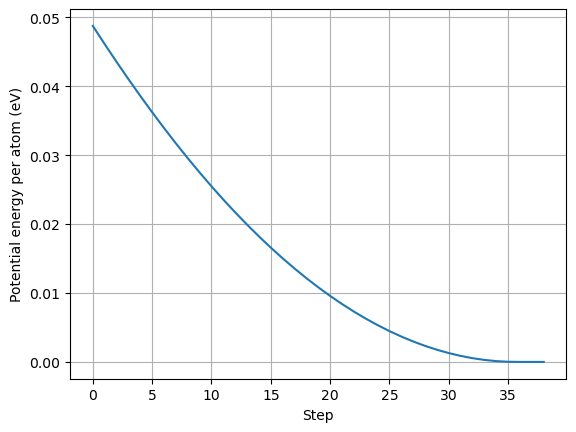

In [26]:
fig, ax = plt.subplots()
ax.plot(step, (pe-pe[-1])/4000)
ax.set(xlabel='Step', ylabel='Potential energy per atom (eV)', title='')
ax.grid()
fig.savefig(path + 'pe.png')
plt.show()

And the corresponding variation in the lattice parameter

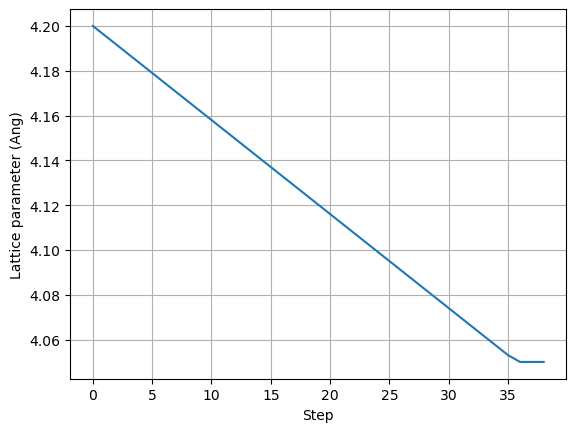

In [27]:
fig, ax = plt.subplots()
ax.plot(step, length/10)
ax.set(xlabel='Step', ylabel='Lattice parameter (Ang)', title='')
ax.grid()
fig.savefig(path + 'a.png')
plt.show()

This is how the pressure varies with lattice parameter (we started with an overestimate of the lattice parameter)

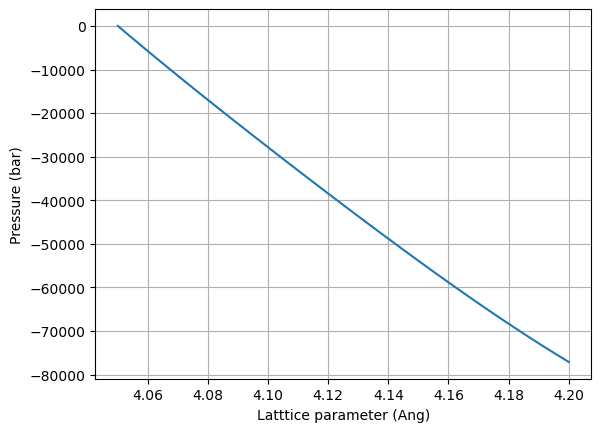

In [28]:
fig, ax = plt.subplots()
ax.plot(length/10, pressure)
ax.set(xlabel='Latttice parameter (Ang)', ylabel='Pressure (bar)', title='')
ax.grid()
fig.savefig(path + 'pressure.png')
plt.show()